In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
dataset_path = '/content/drive/MyDrive/uq_1'
output_csv = 'ndvi_pixel_dataset.csv'
preprocessed_dir = 'preprocessed_images'
clustering_vis_dir = 'visualization/clustering'
outlier_vis_dir = 'visualization/outlier'
summary_vis_dir = 'visualization/summary'

In [ ]:
os.makedirs(summary_vis_dir, exist_ok=True)
os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(clustering_vis_dir, exist_ok=True)
os.makedirs(outlier_vis_dir, exist_ok=True)

In [ ]:
def compute_exg_mask(image, threshold=20):
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    ExG = 2 * G.astype(np.int16) - R.astype(np.int16) - B.astype(np.int16)
    return (ExG > threshold).astype(np.uint8)

In [ ]:
def adaptive_hue_mask(hue, saturation, lightness, Tmin=25, Tmax=65, sat_thresh=50, light_thresh=40):

    #here blur_ksize is 5
    hue = cv2.GaussianBlur(hue, (5, 5), 0)
    saturation = cv2.GaussianBlur(saturation, (5, 5), 0)
    lightness = cv2.GaussianBlur(lightness, (5, 5), 0)

    hue_flat = hue.flatten()
    q1 = np.percentile(hue_flat, 25)
    q3 = np.percentile(hue_flat, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    hue_filtered = hue_flat[(hue_flat >= lower_bound) & (hue_flat <= upper_bound)]

    p5 = np.percentile(hue_filtered, 5)
    p95 = np.percentile(hue_filtered, 95)
    hue_lower = max(Tmin, p5)
    hue_upper = min(Tmax, p95)

    print(f"Hue range used for filtering: {hue_lower:.2f} to {hue_upper:.2f}")

    mask = (hue >= hue_lower) & (hue <= hue_upper) & (saturation >= sat_thresh) & (lightness >= light_thresh)
    return mask.astype(np.uint8)

In [ ]:
def compute_vNDVI(R, G, B):
    R = R / 255.0
    G = G / 255.0
    B = B / 255.0
    G[G == 0] = 0.1
    B[B == 0] = 0.1
    return 0.5268 * (R - 0.1294 * (G ** 0.3389) * (B ** -0.3118))

In [ ]:
def cluster_pixels(pixels, image_shape, mask_coords, image_id, vndvi_per_pixel):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pixels)

    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(scaled)
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    cluster_mean_vndvi = {}
    for cl in np.unique(labels):
        cluster_mean_vndvi[cl] = np.mean(vndvi_per_pixel[labels == cl])

    sorted_clusters = sorted(cluster_mean_vndvi.items(), key=lambda x: x[1], reverse=True)
    color_mapping = {}
    cluster_colors = {
        "Vegetation": [0, 255, 0],
        "Mature": [255, 255, 0],
        "dry_area": [170, 90, 70]
    }
    color_order = ["Vegetation", "Mature", "dry_area"]
    for i, (cl, _) in enumerate(sorted_clusters):
        color_mapping[cl] = cluster_colors[color_order[i]]

    height, width = image_shape[:2]
    vis_img = np.zeros(image_shape, dtype=np.uint8)
    for cl in np.unique(labels):
        coords = mask_coords[labels == cl]
        vis_img[coords[:, 0], coords[:, 1]] = color_mapping[cl]

    out_path = os.path.join(clustering_vis_dir, os.path.basename(image_id).replace('.png', '_cluster.png'))
    cv2.imwrite(out_path, cv2.cvtColor(vis_img, cv2.COLOR_RGB2BGR))

    return labels, cluster_centers, scaled, scaler

In [ ]:
all_data = []
image_vndvi_summary = []
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]

In [ ]:
for img_name in image_files:
    print(f"Processing {img_name}")
    img_path = os.path.join(dataset_path, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (768, 768))

    #Masking
    exg_mask = compute_exg_mask(resized_image)
    hls = cv2.cvtColor(cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2HLS)
    hue, lightness, saturation = hls[:, :, 0].astype(np.float32), hls[:, :, 1].astype(np.float32), hls[:, :, 2].astype(np.float32)
    hue_mask = adaptive_hue_mask(hue, saturation, lightness)
    combined_mask = cv2.bitwise_or(exg_mask, hue_mask)

    #preprocessed image
    filtered_combined = np.where(np.repeat(combined_mask[:, :, np.newaxis], 3, axis=2), resized_image, 0)
    preprocessed_path = os.path.join(preprocessed_dir, img_name.replace('.png', '_filtered.png'))
    cv2.imwrite(preprocessed_path, cv2.cvtColor(filtered_combined, cv2.COLOR_RGB2BGR))

    masked_pixels = filtered_combined[combined_mask == 1]
    if len(masked_pixels) < 10:
        continue

    mask_coords = np.argwhere(combined_mask == 1)
    R_all, G_all, B_all = masked_pixels[:, 0], masked_pixels[:, 1], masked_pixels[:, 2]
    vndvi_all = compute_vNDVI(R_all.astype(np.float32), G_all.astype(np.float32), B_all.astype(np.float32))

    # Save average vNDVI for this image
    avg_vndvi = np.mean(vndvi_all)
    image_vndvi_summary.append({'image_id': img_name, 'avg_vNDVI': avg_vndvi})  # FIXED: Use original img_name

    labels, centers, scaled_pixels, scaler = cluster_pixels(masked_pixels, resized_image.shape, mask_coords, img_name, vndvi_all)

    #outlier removal
    assigned_centers = centers[labels]
    unscaled_pixels = scaler.inverse_transform(scaled_pixels)
    distances = np.linalg.norm(unscaled_pixels - assigned_centers, axis=1)
    threshold = np.percentile(distances, 90)
    keep = distances < threshold
    filtered_pixels = masked_pixels[keep]
    filtered_labels = labels[keep]

    print(f"Image {img_name} has {len(filtered_pixels)} filtered pixels after outlier removal.")

    pixel_ids = np.arange(len(filtered_pixels))

    #outlier visualization
    outlier_img = np.zeros_like(resized_image)
    for (y, x), kf, pix in zip(mask_coords, keep, masked_pixels):
        if kf:
            outlier_img[y, x] = pix
    outlier_path = os.path.join(outlier_vis_dir, img_name.replace('.png', '_outlier_removed.png'))
    cv2.imwrite(outlier_path, cv2.cvtColor(outlier_img, cv2.COLOR_RGB2BGR))

    def resize_img(img, size=(384, 384)):
        return cv2.resize(img, size)

    original_img = resize_img(resized_image)
    filtered_img = resize_img(filtered_combined)
    cluster_img = resize_img(cv2.imread(os.path.join(clustering_vis_dir, img_name.replace('.png', '_cluster.png'))))
    cluster_img = cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB)
    outlier_img_resized = resize_img(outlier_img)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(original_img)
    axs[0].set_title('Original')
    axs[1].imshow(filtered_img)
    axs[1].set_title('Preprocessed')
    axs[2].imshow(cluster_img)
    axs[2].set_title('Clustering')
    axs[3].imshow(outlier_img_resized)
    axs[3].set_title('Outlier Removed')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    summary_path = os.path.join(summary_vis_dir, img_name.replace('.png', '_summary.png'))
    plt.savefig(summary_path)
    plt.close()

    R, G, B = filtered_pixels[:, 0], filtered_pixels[:, 1], filtered_pixels[:, 2]
    vndvi_per_pixel = compute_vNDVI(R.astype(np.float32), G.astype(np.float32), B.astype(np.float32))

    cluster_mean_vndvi = {}
    for cl in np.unique(filtered_labels):
        cluster_mean_vndvi[cl] = np.mean(vndvi_per_pixel[filtered_labels == cl])
    sorted_clusters = sorted(cluster_mean_vndvi.items(), key=lambda x: x[1], reverse=True)
    cluster_name_map = {}
    labels_human = ["Vegetation", "Mature", "dry_area"]
    for i, (cl, _) in enumerate(sorted_clusters):
        cluster_name_map[cl] = labels_human[i]
    cluster_labels_named = [cluster_name_map[label] for label in filtered_labels]

    df = pd.DataFrame({
        'image_id': img_name,  # FIXED: Use original img_name instead of outlier_path
        'pixel_id': pixel_ids,
        'R': R,
        'G': G,
        'B': B,
        'cluster': filtered_labels,
        'cluster_label': cluster_labels_named,
        'vNDVI': vndvi_per_pixel
    })
    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv(output_csv, index=False)

vndvi_df = pd.DataFrame(image_vndvi_summary)
vndvi_df.to_csv('image_avg_vndvi.csv', index=False)

print(f"\n1. Dataset saved to {output_csv}")
print(f"2. Preprocessed images saved to: {preprocessed_dir}")
print(f"3. Clustering visualizations saved to: {clustering_vis_dir}")
print(f"4. Outlier removal visualizations saved to: {outlier_vis_dir}")
print(f"5. Summary visualizations saved to: {summary_vis_dir}")
print(f"6. Image-wise average vNDVI saved to: image_avg_vndvi.csv")


Processing 063b1190-8045-4b6b-ae85-731475d82ca0.png
Hue range used for filtering: 25.00 to 60.72
Image 063b1190-8045-4b6b-ae85-731475d82ca0.png has 342245 filtered pixels after outlier removal.
Processing 0ad00024-7a7d-4891-9557-53bcc9430273.png
Hue range used for filtering: 25.00 to 40.13
Image 0ad00024-7a7d-4891-9557-53bcc9430273.png has 279574 filtered pixels after outlier removal.
Processing 05ef37c9-e9d7-4142-bd66-4ed62db9016a.png
Hue range used for filtering: 25.00 to 61.95
Image 05ef37c9-e9d7-4142-bd66-4ed62db9016a.png has 408333 filtered pixels after outlier removal.
Processing 02c35db8-48f7-47b5-a308-f5f052d1829d.png
Hue range used for filtering: 28.06 to 54.63
Image 02c35db8-48f7-47b5-a308-f5f052d1829d.png has 468671 filtered pixels after outlier removal.
Processing 09b78985-f9eb-48ff-a37e-3cd6c824375a.png
Hue range used for filtering: 25.00 to 44.74
Image 09b78985-f9eb-48ff-a37e-3cd6c824375a.png has 180166 filtered pixels after outlier removal.
Processing 0417af10-8dfd-495b-

Using device: cuda
Found 142 valid image-label pairs
Found 142 valid image-label pairs
Dataset splits: Train=99, Val=21, Test=22

Improved Model Summary:
Total parameters: 3,732,451

Starting improved training...


Epoch [10/150]
Train - Loss: 0.001110, R²: 0.7142
Val   - Loss: 0.000474, R²: 0.8696
Best Val R²: -inf
LR: 5.00e-04
--------------------------------------------------


Epoch [20/150]
Train - Loss: 0.001473, R²: 0.7986
Val   - Loss: 0.000538, R²: 0.8689
Best Val R²: -inf
LR: 3.50e-04
--------------------------------------------------


Epoch [30/150]
Train - Loss: 0.000675, R²: 0.8190
Val   - Loss: 0.000320, R²: 0.9136
Best Val R²: -inf
LR: 3.50e-04
--------------------------------------------------


Epoch [40/150]
Train - Loss: 0.001108, R²: 0.7016
Val   - Loss: 0.001382, R²: 0.7058
Best Val R²: -inf
LR: 2.45e-04
--------------------------------------------------


Epoch [50/150]
Train - Loss: 0.000623, R²: 0.8423
Val   - Loss: 0.000406, R²: 0.8867
Best Val R²: -inf
LR: 1.71e-04
--------------------------------------------------
Early stopping at epoch 50

Evaluating on test set...

IMPROVED MODEL TEST RESULTS
MSE:  0.000281
RMSE: 0.016759
R²:   0.9129
MAE:  0.012871
MAPE: 7.66%


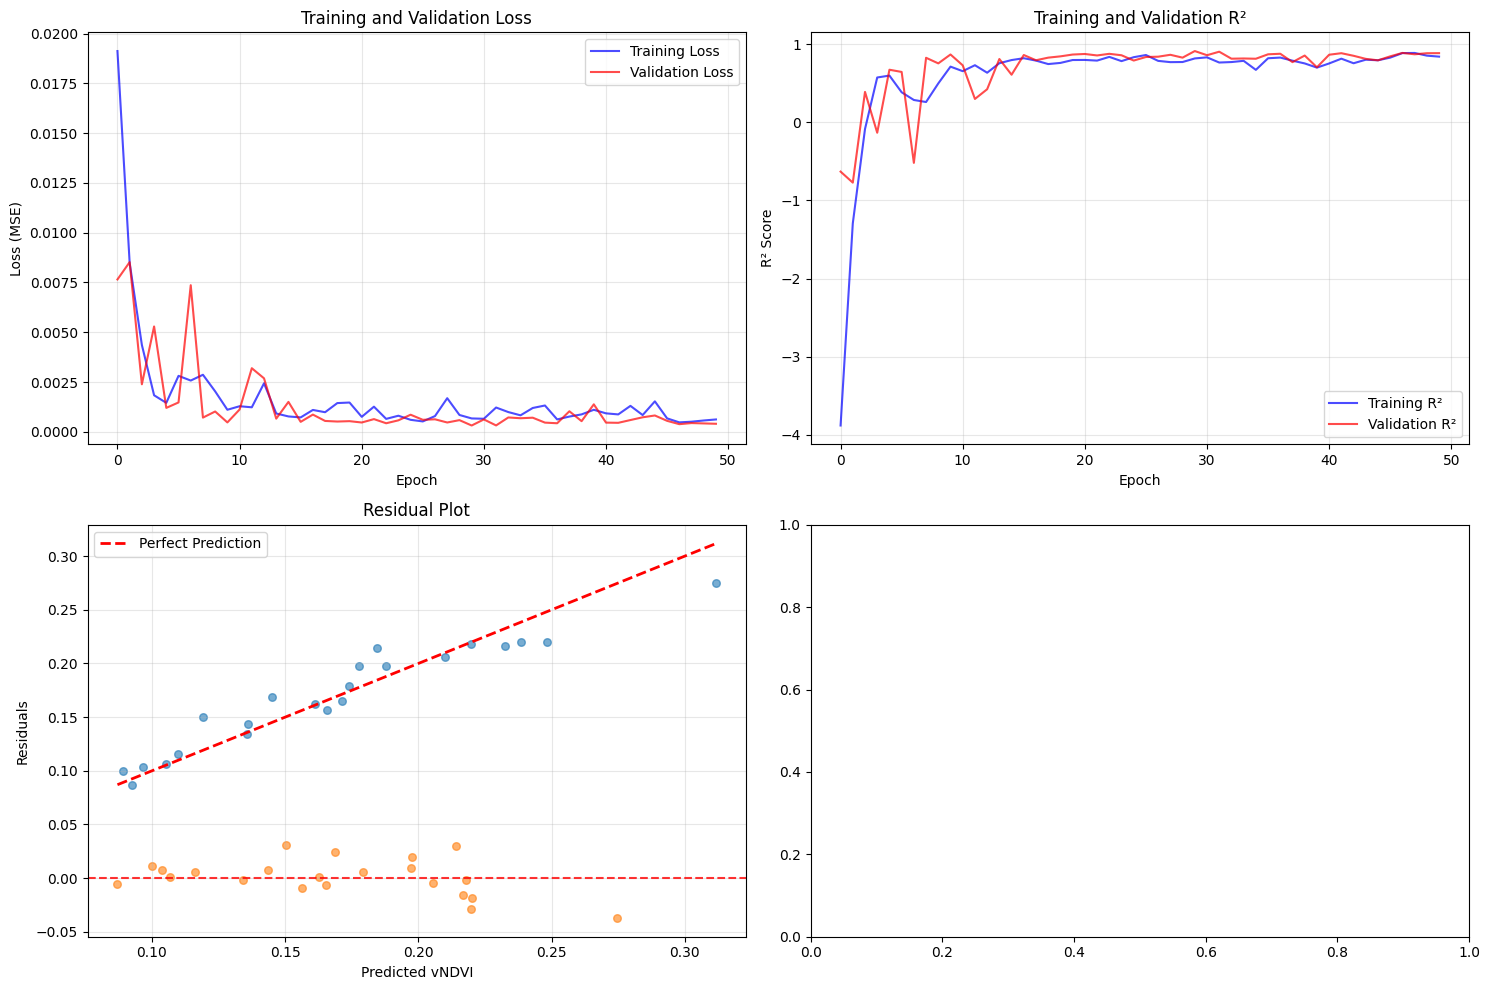


Improved model saved!
Training history saved!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set device for Google Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ImprovedVNDVINet(nn.Module):
    """
    Improved CNN based on your successful original architecture
    Key improvements: Better regularization, optimized depth, attention mechanism
    """
    def __init__(self, input_size=224):
        super(ImprovedVNDVINet, self).__init__()

        # Convolutional layers - similar to original but with improvements
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Changed stride to 1
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # Added one more layer

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Fixed size output

        # Attention mechanism - Simple but effective
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 512//8, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(512//8, 512, 1, bias=False),
            nn.Sigmoid()
        )

        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

        # Classifier - Similar structure to original but optimized
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Reduced dropout
            nn.Linear(512 * 16, 256),  # 512 channels * 4*4 spatial
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature extraction - Progressive downsampling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 112x112

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 28x28

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # 7x7

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.adaptive_pool(x)  # 4x4

        # Apply attention mechanisms
        # Channel attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa

        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

class VNDVIDataset(Dataset):
    def __init__(self, csv_file, preprocessed_dir, transform=None):
        self.vndvi_df = pd.read_csv(csv_file)
        self.preprocessed_dir = preprocessed_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.missing_files = []

        for _, row in self.vndvi_df.iterrows():
            img_name = row['image_id']
            preprocessed_name = img_name.replace('.png', '_outlier_removed.png')
            img_path = os.path.join(preprocessed_dir, preprocessed_name)

            if os.path.exists(img_path):
                self.image_paths.append(img_path)
                self.labels.append(row['avg_vNDVI'])
            else:
                self.missing_files.append(img_path)

        print(f"Found {len(self.image_paths)} valid image-label pairs")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

def get_conservative_transforms():
    """Conservative data augmentation - less aggressive than before"""
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),  # Reduced probability
        transforms.RandomRotation(degrees=10),    # Reduced rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Reduced jitter
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_model(model, train_loader, val_loader, num_epochs=150, learning_rate=5e-4):
    """
    Optimized training loop based on your successful configuration
    """
    # Use MSE like your original (which worked well)
    criterion = nn.MSELoss()

    # Use Adam with conservative settings
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # More conservative learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=8, min_lr=1e-6
    )

    early_stopping = EarlyStopping(patience=20, min_delta=1e-6)

    train_losses = []
    val_losses = []
    train_r2s = []
    val_r2s = []

    best_val_r2 = -float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if labels.dim() == 0:
                labels = labels.unsqueeze(0)

            loss = criterion(outputs, labels)
            loss.backward()

            # Conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()

            train_loss += loss.item()
            train_predictions.extend(outputs.detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate metrics
        train_predictions = np.array(train_predictions)
        train_targets = np.array(train_targets)
        train_r2 = r2_score(train_targets, train_predictions)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_r2s.append(train_r2)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()

                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                if labels.dim() == 0:
                    labels = labels.unsqueeze(0)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_predictions = np.array(val_predictions)
        val_targets = np.array(val_targets)
        val_r2 = r2_score(val_targets, val_predictions)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_r2s.append(val_r2)

        scheduler.step(avg_val_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train - Loss: {avg_train_loss:.6f}, R²: {train_r2:.4f}')
            print(f'Val   - Loss: {avg_val_loss:.6f}, R²: {val_r2:.4f}')
            print(f'Best Val R²: {best_val_r2:.4f}')
            print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
            print('-' * 50)

        if early_stopping(avg_val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model based on R²
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation R² = {best_val_r2:.4f}")

    return train_losses, val_losses, train_r2s, val_r2s

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actual_values = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()

            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if labels.dim() == 0:
                labels = labels.unsqueeze(0)

            predictions.extend(outputs.cpu().numpy())
            actual_values.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    actual_values = np.array(actual_values)

    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_values, predictions)
    mae = np.mean(np.abs(actual_values - predictions))
    mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100

    print(f"\n{'='*50}")
    print(f"IMPROVED MODEL TEST RESULTS")
    print(f"{'='*50}")
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  {mae:.6f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"{'='*50}")

    return predictions, actual_values, mse, rmse, r2, mae, mape

def plot_results(train_losses, val_losses, train_r2s, val_r2s, predictions, actual_values):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # R² curves
    axes[0, 1].plot(train_r2s, label='Training R²', color='blue', alpha=0.7)
    axes[0, 1].plot(val_r2s, label='Validation R²', color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('Training and Validation R²')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Predictions vs Actual
    axes[1, 0].scatter(actual_values, predictions, alpha=0.6, s=30)
    min_val = min(actual_values.min(), predictions.min())
    max_val = max(actual_values.max(), predictions.max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[1, 0].set_xlabel('Actual vNDVI')
    axes[1, 0].set_ylabel('Predicted vNDVI')
    axes[1, 0].set_title('Predictions vs Actual Values')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals
    residuals = predictions - actual_values
    axes[1, 0].scatter(predictions, residuals, alpha=0.6, s=30)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
    axes[1, 0].set_xlabel('Predicted vNDVI')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residual Plot')
    axes[1, 0].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('improved_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Paths
    csv_file = '/content/image_avg_vndvi.csv'
    preprocessed_dir = '/content/visualization/outlier'

    if not os.path.exists(csv_file) or not os.path.exists(preprocessed_dir):
        print("Error: Required files not found!")
        return

    # Conservative data augmentation
    train_transforms, val_transforms = get_conservative_transforms()

    # Create datasets
    train_dataset = VNDVIDataset(csv_file, preprocessed_dir, transform=train_transforms)
    val_test_dataset = VNDVIDataset(csv_file, preprocessed_dir, transform=val_transforms)

    if len(train_dataset) == 0:
        print("Error: No valid image-label pairs found!")
        return

    # Dataset splits
    total_size = len(train_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, _ = random_split(train_dataset, [train_size, total_size - train_size],
                                  generator=torch.Generator().manual_seed(42))

    _, val_test_dataset = random_split(val_test_dataset, [train_size, total_size - train_size],
                                      generator=torch.Generator().manual_seed(42))
    val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size],
                                           generator=torch.Generator().manual_seed(42))

    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Create improved model
    model = ImprovedVNDVINet().to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nImproved Model Summary:")
    print(f"Total parameters: {total_params:,}")

    # Train model
    print("\nStarting improved training...")
    train_losses, val_losses, train_r2s, val_r2s = train_model(
        model, train_loader, val_loader, num_epochs=150, learning_rate=5e-4
    )

    # Evaluate model
    print("\nEvaluating on test set...")
    predictions, actual_values, mse, rmse, r2, mae, mape = evaluate_model(model, test_loader)

    # Plot results
    plot_results(train_losses, val_losses, train_r2s, val_r2s, predictions, actual_values)

    # Save model
    torch.save(model.state_dict(), 'improved_vndvi_cnn_model.pth')
    print("\nImproved model saved!")

    # Save results
    history_df = pd.DataFrame({
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_r2': train_r2s,
        'val_r2': val_r2s
    })
    history_df.to_csv('improved_training_history.csv', index=False)
    print("Training history saved!")

if __name__ == "__main__":
    main()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

dataset_path = '/content/drive/MyDrive/uq_1'
output_csv = 'ndvi_pixel_dataset.csv'
preprocessed_dir = 'preprocessed_images'
clustering_vis_dir = 'visualization/clustering'
outlier_vis_dir = 'visualization/outlier'
summary_vis_dir = 'visualization/summary'

os.makedirs(summary_vis_dir, exist_ok=True)
os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(clustering_vis_dir, exist_ok=True)
os.makedirs(outlier_vis_dir, exist_ok=True)

def compute_exg_mask(image, threshold=20):
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    ExG = 2 * G.astype(np.int16) - R.astype(np.int16) - B.astype(np.int16)
    return (ExG > threshold).astype(np.uint8)

def adaptive_hue_mask(hue, saturation, lightness, Tmin=25, Tmax=65, sat_thresh=50, light_thresh=40):
    hue = cv2.GaussianBlur(hue, (5, 5), 0)
    saturation = cv2.GaussianBlur(saturation, (5, 5), 0)
    lightness = cv2.GaussianBlur(lightness, (5, 5), 0)

    hue_flat = hue.flatten()
    q1 = np.percentile(hue_flat, 25)
    q3 = np.percentile(hue_flat, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    hue_filtered = hue_flat[(hue_flat >= lower_bound) & (hue_flat <= upper_bound)]

    p5 = np.percentile(hue_filtered, 5)
    p95 = np.percentile(hue_filtered, 95)
    hue_lower = max(Tmin, p5)
    hue_upper = min(Tmax, p95)

    print(f"Hue range used for filtering: {hue_lower:.2f} to {hue_upper:.2f}")

    mask = (hue >= hue_lower) & (hue <= hue_upper) & (saturation >= sat_thresh) & (lightness >= light_thresh)
    return mask.astype(np.uint8)

def compute_vNDVI(R, G, B):
    R = R / 255.0
    G = G / 255.0
    B = B / 255.0
    G[G == 0] = 0.1
    B[B == 0] = 0.1
    return 0.5268 * (R - 0.1294 * (G ** 0.3389) * (B ** -0.3118))

def compute_MGRVI(R, G, B):
    """
    Compute Modified Green Red Vegetation Index (MGRVI)
    MGRVI = (G^2 - R^2) / (G^2 + R^2)
    """
    R = R.astype(np.float32)
    G = G.astype(np.float32)

    numerator = G**2 - R**2
    denominator = G**2 + R**2
    denominator[denominator == 0] = 1e-8
    mgrvi = numerator / denominator
    return mgrvi

def compute_VARI(R, G, B):
    """
    Compute Visible Atmospherically Resistant Index (VARI)
    VARI = (G - R) / (G + R - B)
    """
    R = R.astype(np.float32)
    G = G.astype(np.float32)
    B = B.astype(np.float32)

    numerator = G - R
    denominator = G + R - B
    denominator[denominator == 0] = 1e-8
    vari = numerator / denominator
    return vari

def cluster_pixels(pixels, image_shape, mask_coords, image_id, vndvi_per_pixel):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pixels)

    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(scaled)
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    cluster_mean_vndvi = {}
    for cl in np.unique(labels):
        cluster_mean_vndvi[cl] = np.mean(vndvi_per_pixel[labels == cl])

    sorted_clusters = sorted(cluster_mean_vndvi.items(), key=lambda x: x[1], reverse=True)
    color_mapping = {}
    cluster_colors = {
        "Vegetation": [0, 255, 0],
        "Mature": [255, 255, 0],
        "dry_area": [170, 90, 70]
    }
    color_order = ["Vegetation", "Mature", "dry_area"]
    for i, (cl, _) in enumerate(sorted_clusters):
        color_mapping[cl] = cluster_colors[color_order[i]]

    height, width = image_shape[:2]
    vis_img = np.zeros(image_shape, dtype=np.uint8)
    for cl in np.unique(labels):
        coords = mask_coords[labels == cl]
        vis_img[coords[:, 0], coords[:, 1]] = color_mapping[cl]

    out_path = os.path.join(clustering_vis_dir, os.path.basename(image_id).replace('.png', '_cluster.png'))
    cv2.imwrite(out_path, cv2.cvtColor(vis_img, cv2.COLOR_RGB2BGR))

    return labels, cluster_centers, scaled, scaler

all_data = []
image_vndvi_summary = []
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]

for img_name in image_files:
    print(f"Processing {img_name}")
    img_path = os.path.join(dataset_path, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (768, 768))

    # Masking
    exg_mask = compute_exg_mask(resized_image)
    hls = cv2.cvtColor(cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2HLS)
    hue, lightness, saturation = hls[:, :, 0].astype(np.float32), hls[:, :, 1].astype(np.float32), hls[:, :, 2].astype(np.float32)
    hue_mask = adaptive_hue_mask(hue, saturation, lightness)
    combined_mask = cv2.bitwise_or(exg_mask, hue_mask)

    # Preprocessed image
    filtered_combined = np.where(np.repeat(combined_mask[:, :, np.newaxis], 3, axis=2), resized_image, 0)
    preprocessed_path = os.path.join(preprocessed_dir, img_name.replace('.png', '_filtered.png'))
    cv2.imwrite(preprocessed_path, cv2.cvtColor(filtered_combined, cv2.COLOR_RGB2BGR))

    masked_pixels = filtered_combined[combined_mask == 1]
    if len(masked_pixels) < 10:
        continue

    mask_coords = np.argwhere(combined_mask == 1)
    R_all, G_all, B_all = masked_pixels[:, 0], masked_pixels[:, 1], masked_pixels[:, 2]

    # Compute all vegetation indices
    vndvi_all = compute_vNDVI(R_all.astype(np.float32), G_all.astype(np.float32), B_all.astype(np.float32))
    mgrvi_all = compute_MGRVI(R_all, G_all, B_all)
    vari_all = compute_VARI(R_all, G_all, B_all)

    # Save average indices for this image
    avg_vndvi = np.mean(vndvi_all)
    avg_mgrvi = np.mean(mgrvi_all)
    avg_vari = np.mean(vari_all)

    image_vndvi_summary.append({
        'image_id': img_name,
        'avg_vNDVI': avg_vndvi,
        'avg_MGRVI': avg_mgrvi,
        'avg_VARI': avg_vari
    })

    labels, centers, scaled_pixels, scaler = cluster_pixels(masked_pixels, resized_image.shape, mask_coords, img_name, vndvi_all)

    # Outlier removal
    assigned_centers = centers[labels]
    unscaled_pixels = scaler.inverse_transform(scaled_pixels)
    distances = np.linalg.norm(unscaled_pixels - assigned_centers, axis=1)
    threshold = np.percentile(distances, 90)
    keep = distances < threshold
    filtered_pixels = masked_pixels[keep]
    filtered_labels = labels[keep]

    print(f"Image {img_name} has {len(filtered_pixels)} filtered pixels after outlier removal.")

    pixel_ids = np.arange(len(filtered_pixels))

    # Outlier visualization
    outlier_img = np.zeros_like(resized_image)
    for (y, x), kf, pix in zip(mask_coords, keep, masked_pixels):
        if kf:
            outlier_img[y, x] = pix
    outlier_path = os.path.join(outlier_vis_dir, img_name.replace('.png', '_outlier_removed.png'))
    cv2.imwrite(outlier_path, cv2.cvtColor(outlier_img, cv2.COLOR_RGB2BGR))

    def resize_img(img, size=(384, 384)):
        return cv2.resize(img, size)

    original_img = resize_img(resized_image)
    filtered_img = resize_img(filtered_combined)
    cluster_img = resize_img(cv2.imread(os.path.join(clustering_vis_dir, img_name.replace('.png', '_cluster.png'))))
    cluster_img = cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB)
    outlier_img_resized = resize_img(outlier_img)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(original_img)
    axs[0].set_title('Original')
    axs[1].imshow(filtered_img)
    axs[1].set_title('Preprocessed')
    axs[2].imshow(cluster_img)
    axs[2].set_title('Clustering')
    axs[3].imshow(outlier_img_resized)
    axs[3].set_title('Outlier Removed')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    summary_path = os.path.join(summary_vis_dir, img_name.replace('.png', '_summary.png'))
    plt.savefig(summary_path)
    plt.close()

    R, G, B = filtered_pixels[:, 0], filtered_pixels[:, 1], filtered_pixels[:, 2]
    vndvi_per_pixel = compute_vNDVI(R.astype(np.float32), G.astype(np.float32), B.astype(np.float32))
    mgrvi_per_pixel = compute_MGRVI(R, G, B)
    vari_per_pixel = compute_VARI(R, G, B)

    cluster_mean_vndvi = {}
    for cl in np.unique(filtered_labels):
        cluster_mean_vndvi[cl] = np.mean(vndvi_per_pixel[filtered_labels == cl])
    sorted_clusters = sorted(cluster_mean_vndvi.items(), key=lambda x: x[1], reverse=True)
    cluster_name_map = {}
    labels_human = ["Vegetation", "Mature", "dry_area"]
    for i, (cl, _) in enumerate(sorted_clusters):
        cluster_name_map[cl] = labels_human[i]
    cluster_labels_named = [cluster_name_map[label] for label in filtered_labels]

    df = pd.DataFrame({
        'image_id': img_name,
        'pixel_id': pixel_ids,
        'R': R,
        'G': G,
        'B': B,
        'cluster': filtered_labels,
        'cluster_label': cluster_labels_named,
        'vNDVI': vndvi_per_pixel,
        'MGRVI': mgrvi_per_pixel,
        'VARI': vari_per_pixel
    })
    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv(output_csv, index=False)

vndvi_df = pd.DataFrame(image_vndvi_summary)
vndvi_df.to_csv('image_avg_indices.csv', index=False)

print(f"\n1. Dataset saved to {output_csv}")
print(f"2. Preprocessed images saved to: {preprocessed_dir}")
print(f"3. Clustering visualizations saved to: {clustering_vis_dir}")
print(f"4. Outlier removal visualizations saved to: {outlier_vis_dir}")
print(f"5. Summary visualizations saved to: {summary_vis_dir}")
print(f"6. Image-wise average indices saved to: image_avg_indices.csv")


Processing 063b1190-8045-4b6b-ae85-731475d82ca0.png
Hue range used for filtering: 25.00 to 60.72
Image 063b1190-8045-4b6b-ae85-731475d82ca0.png has 342245 filtered pixels after outlier removal.
Processing 0ad00024-7a7d-4891-9557-53bcc9430273.png
Hue range used for filtering: 25.00 to 40.13
Image 0ad00024-7a7d-4891-9557-53bcc9430273.png has 279574 filtered pixels after outlier removal.
Processing 05ef37c9-e9d7-4142-bd66-4ed62db9016a.png
Hue range used for filtering: 25.00 to 61.95
Image 05ef37c9-e9d7-4142-bd66-4ed62db9016a.png has 408333 filtered pixels after outlier removal.
Processing 02c35db8-48f7-47b5-a308-f5f052d1829d.png
Hue range used for filtering: 28.06 to 54.63
Image 02c35db8-48f7-47b5-a308-f5f052d1829d.png has 468671 filtered pixels after outlier removal.
Processing 09b78985-f9eb-48ff-a37e-3cd6c824375a.png
Hue range used for filtering: 25.00 to 44.74
Image 09b78985-f9eb-48ff-a37e-3cd6c824375a.png has 180166 filtered pixels after outlier removal.
Processing 0417af10-8dfd-495b-

Using device: cuda
Found 142 valid image-label pairs
Total images: 142
Train size: 99 (69.7%)
Val size: 21 (14.8%)
Test size: 22 (15.5%)
Dataset splits: Train=99, Val=21, Test=22

Multi-Output Model Summary:
Total parameters: 3,732,581

Starting multi-output training...


Epoch [10/150]
Train - Loss: 83454.502937, R²: 0.3442
Val   - Loss: 0.004023, R²: 0.6425
Best Val Loss: 0.002740
LR: 5.00e-04
--------------------------------------------------


Epoch [20/150]
Train - Loss: 83436.003231, R²: 0.4303
Val   - Loss: 0.009714, R²: 0.3278
Best Val Loss: 0.001332
LR: 5.00e-04
--------------------------------------------------


Epoch [30/150]
Train - Loss: 83334.555583, R²: -0.0551
Val   - Loss: 0.002623, R²: 0.7146
Best Val Loss: 0.001332
LR: 3.50e-04
--------------------------------------------------


Epoch [40/150]
Train - Loss: 82844.484893, R²: -3.2575
Val   - Loss: 0.002093, R²: 0.7257
Best Val Loss: 0.001049
LR: 2.45e-04
--------------------------------------------------


Epoch [50/150]
Train - Loss: 82140.859068, R²: -11.5230
Val   - Loss: 0.001740, R²: 0.8446
Best Val Loss: 0.000540
LR: 2.45e-04
--------------------------------------------------


Epoch [60/150]
Train - Loss: 80756.680023, R²: -28.8061
Val   - Loss: 0.000345, R²: 0.9587
Best Val Loss: 0.000326
LR: 1.71e-04
--------------------------------------------------


Epoch [70/150]
Train - Loss: 79744.090553, R²: -44.2547
Val   - Loss: 0.000969, R²: 0.8993
Best Val Loss: 0.000326
LR: 1.20e-04
--------------------------------------------------


Early stopping at epoch 79
Loaded best model with validation loss = 0.000326

Evaluating on test set...

vNDVI Results:
MSE:  0.000324
RMSE: 0.018005
R²:   0.9115
MAE:  0.013260
MAPE: 8.65%

MGRVI Results:
MSE:  0.001134
RMSE: 0.033677
R²:   0.9049
MAE:  0.029126
MAPE: 38.19%

VARI Results:
MSE:  0.000959
RMSE: 0.030968
R²:   0.8704
MAE:  0.024524
MAPE: 44.94%


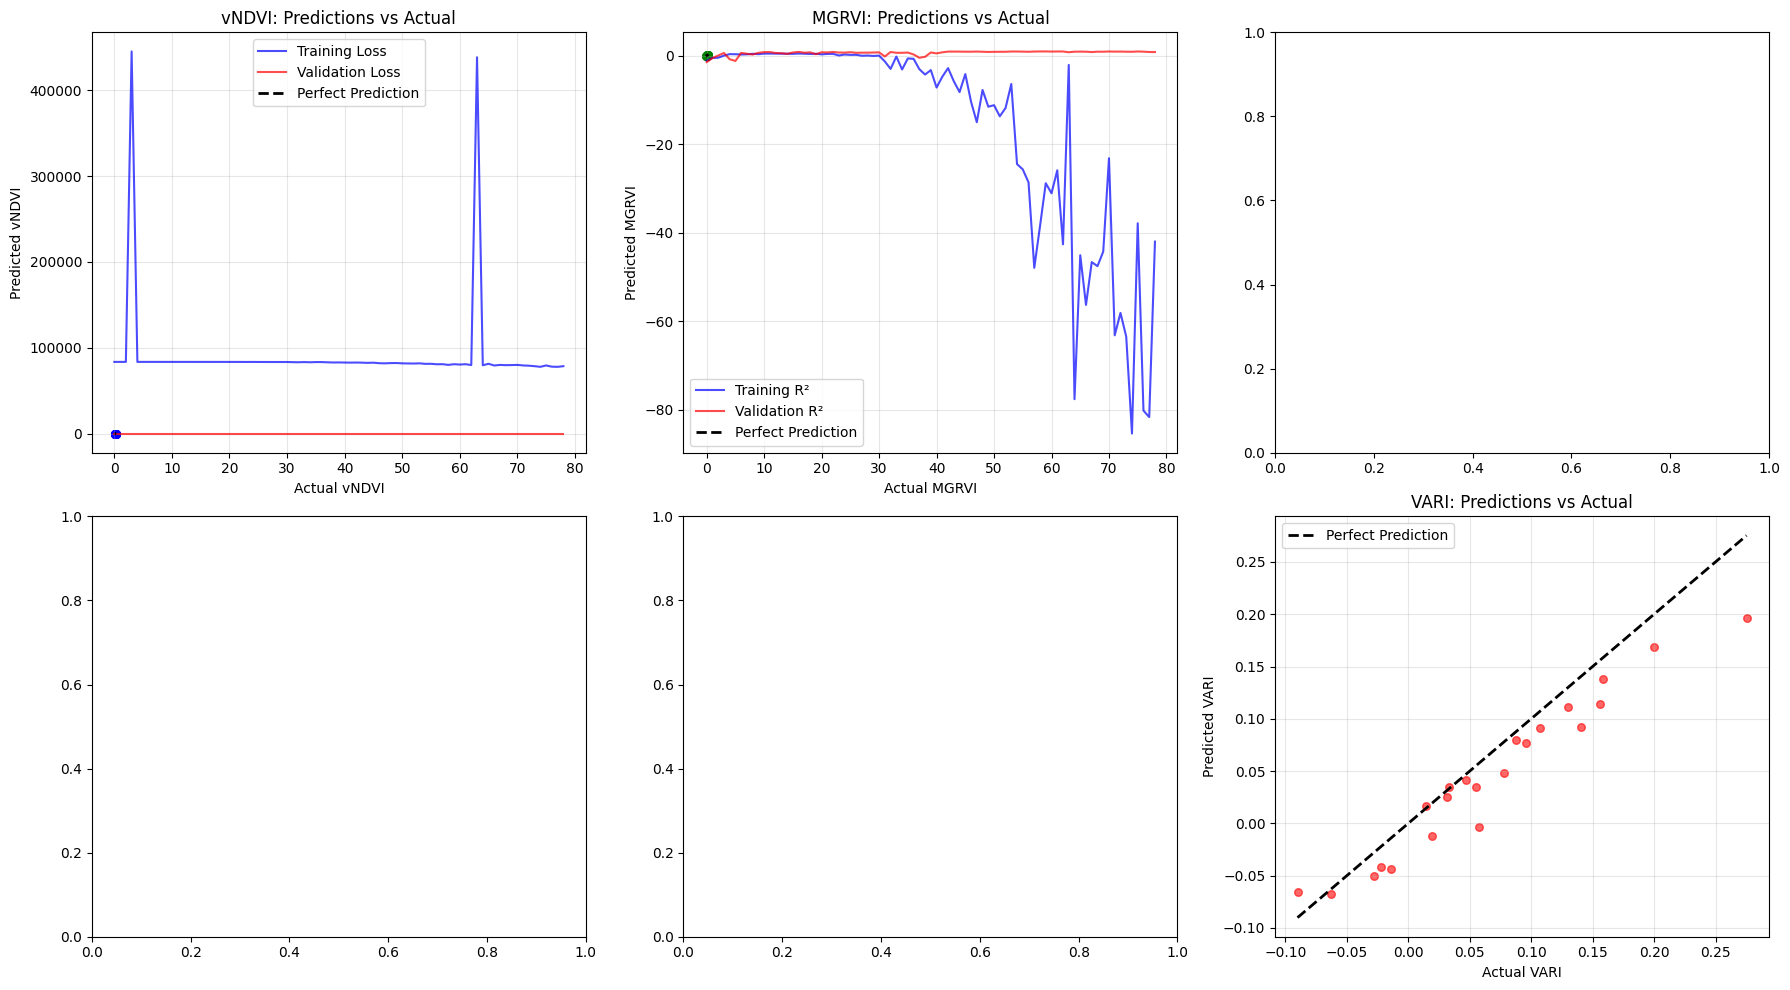


Predicting all images...
Predictions for ALL 142 images saved to vegetation_indices_predictions_ALL_IMAGES.xlsx

Multi-output model saved!
Training history saved!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set device for Google Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class MultiOutputVNDVINet(nn.Module):
    """
    CNN model to predict multiple vegetation indices
    """
    def __init__(self, input_size=224, num_outputs=3):
        super(MultiOutputVNDVINet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Attention mechanism
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 512//8, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(512//8, 512, 1, bias=False),
            nn.Sigmoid()
        )

        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

        # Classifier for multiple outputs
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(64, num_outputs)  # Output for multiple indices
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 112x112

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 28x28

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # 7x7

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.adaptive_pool(x)  # 4x4

        # Apply attention mechanisms
        # Channel attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa

        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

class MultiOutputVNDVIDataset(Dataset):
    def __init__(self, csv_file, preprocessed_dir, transform=None):
        self.indices_df = pd.read_csv(csv_file)
        self.preprocessed_dir = preprocessed_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.missing_files = []

        for _, row in self.indices_df.iterrows():
            img_name = row['image_id']
            preprocessed_name = img_name.replace('.png', '_outlier_removed.png')
            img_path = os.path.join(preprocessed_dir, preprocessed_name)

            if os.path.exists(img_path):
                self.image_paths.append(img_path)
                # Store all three indices as labels
                self.labels.append([row['avg_vNDVI'], row['avg_MGRVI'], row['avg_VARI']])
            else:
                self.missing_files.append(img_path)

        print(f"Found {len(self.image_paths)} valid image-label pairs")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        labels = self.labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels, dtype=torch.float32)

def get_conservative_transforms():
    """Conservative data augmentation"""
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_multi_output_model(model, train_loader, val_loader, num_epochs=150, learning_rate=5e-4):
    """
    Training loop for multi-output model
    """
    # Use MSE loss for all outputs
    criterion = nn.MSELoss()

    # Use Adam with conservative settings
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=8, min_lr=1e-6
    )

    early_stopping = EarlyStopping(patience=20, min_delta=1e-6)

    train_losses = []
    val_losses = []
    train_r2s = []
    val_r2s = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()

            train_loss += loss.item()
            train_predictions.extend(outputs.detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate metrics
        train_predictions = np.array(train_predictions)
        train_targets = np.array(train_targets)

        # Calculate R² for each output
        train_r2_vndvi = r2_score(train_targets[:, 0], train_predictions[:, 0])
        train_r2_mgrvi = r2_score(train_targets[:, 1], train_predictions[:, 1])
        train_r2_vari = r2_score(train_targets[:, 2], train_predictions[:, 2])

        # Use average R²
        train_r2 = (train_r2_vndvi + train_r2_mgrvi + train_r2_vari) / 3

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_r2s.append(train_r2)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_predictions = np.array(val_predictions)
        val_targets = np.array(val_targets)

        # Calculate R² for each output
        val_r2_vndvi = r2_score(val_targets[:, 0], val_predictions[:, 0])
        val_r2_mgrvi = r2_score(val_targets[:, 1], val_predictions[:, 1])
        val_r2_vari = r2_score(val_targets[:, 2], val_predictions[:, 2])

        # Use average R²
        val_r2 = (val_r2_vndvi + val_r2_mgrvi + val_r2_vari) / 3

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_r2s.append(val_r2)

        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train - Loss: {avg_train_loss:.6f}, R²: {train_r2:.4f}')
            print(f'Val   - Loss: {avg_val_loss:.6f}, R²: {val_r2:.4f}')
            print(f'Best Val Loss: {best_val_loss:.6f}')
            print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
            print('-' * 50)

        if early_stopping(avg_val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss = {best_val_loss:.6f}")

    return train_losses, val_losses, train_r2s, val_r2s

def predict_all_images(model, data_loader):
    """Predict all images in the given data loader"""
    model.eval()
    predictions = []
    actual_values = []
    image_paths = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)

            predictions.extend(outputs.cpu().numpy())
            actual_values.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(actual_values)

def evaluate_multi_output_model(model, test_loader):
    model.eval()
    predictions = []
    actual_values = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            predictions.extend(outputs.cpu().numpy())
            actual_values.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    actual_values = np.array(actual_values)

    # Calculate metrics for each output
    metrics = {}
    index_names = ['vNDVI', 'MGRVI', 'VARI']

    for i, name in enumerate(index_names):
        mse = mean_squared_error(actual_values[:, i], predictions[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(actual_values[:, i], predictions[:, i])
        mae = np.mean(np.abs(actual_values[:, i] - predictions[:, i]))
        mape = np.mean(np.abs((actual_values[:, i] - predictions[:, i]) / actual_values[:, i])) * 100

        metrics[name] = {
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'mape': mape
        }

        print(f"\n{name} Results:")
        print(f"MSE:  {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²:   {r2:.4f}")
        print(f"MAE:  {mae:.6f}")
        print(f"MAPE: {mape:.2f}%")

    return predictions, actual_values, metrics

def plot_multi_results(train_losses, val_losses, train_r2s, val_r2s, predictions, actual_values):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # R² curves
    axes[0, 1].plot(train_r2s, label='Training R²', color='blue', alpha=0.7)
    axes[0, 1].plot(val_r2s, label='Validation R²', color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('Training and Validation R²')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Predictions vs Actual for each index
    index_names = ['vNDVI', 'MGRVI', 'VARI']
    colors = ['blue', 'green', 'red']

    for i, (name, color) in enumerate(zip(index_names, colors)):
        row = 1 if i == 2 else 0
        col = 2 if i == 2 else i

        axes[row, col].scatter(actual_values[:, i], predictions[:, i], alpha=0.6, s=30, color=color)
        min_val = min(actual_values[:, i].min(), predictions[:, i].min())
        max_val = max(actual_values[:, i].max(), predictions[:, i].max())
        axes[row, col].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
        axes[row, col].set_xlabel(f'Actual {name}')
        axes[row, col].set_ylabel(f'Predicted {name}')
        axes[row, col].set_title(f'{name}: Predictions vs Actual')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('multi_output_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Paths
    csv_file = '/content/image_avg_indices.csv'
    preprocessed_dir = '/content/visualization/outlier'

    if not os.path.exists(csv_file) or not os.path.exists(preprocessed_dir):
        print("Error: Required files not found!")
        return

    # Create the base dataset without transforms for consistent splitting
    full_dataset = MultiOutputVNDVIDataset(csv_file, preprocessed_dir, transform=None)

    if len(full_dataset) == 0:
        print("Error: No valid image-label pairs found!")
        return

    # Dataset splits for training and validation
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    print(f"Total images: {total_size}")
    print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
    print(f"Val size: {val_size} ({val_size/total_size*100:.1f}%)")
    print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

    # Generate indices first, then create subsets
    indices = list(range(total_size))
    train_indices, temp_indices = random_split(
        indices,
        [train_size, total_size - train_size],
        generator=torch.Generator().manual_seed(42)
    )
    val_indices, test_indices = random_split(
        temp_indices.indices,
        [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create subsets using the indices
    train_subset = torch.utils.data.Subset(full_dataset, train_indices.indices)
    val_subset = torch.utils.data.Subset(full_dataset, val_indices.indices)
    test_subset = torch.utils.data.Subset(full_dataset, test_indices.indices)

    print(f"Dataset splits: Train={len(train_subset)}, Val={len(val_subset)}, Test={len(test_subset)}")

    # Apply different transforms to each subset
    train_transforms, val_transforms = get_conservative_transforms()

    # Create wrapper datasets that apply transforms
    class TransformedSubset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            image, label = self.subset[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    train_dataset = TransformedSubset(train_subset, train_transforms)
    val_dataset = TransformedSubset(val_subset, val_transforms)
    test_dataset = TransformedSubset(test_subset, val_transforms)

    # Create multi-output model
    model = MultiOutputVNDVINet(num_outputs=3).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nMulti-Output Model Summary:")
    print(f"Total parameters: {total_params:,}")

    # Create data loaders for training
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Train model
    print("\nStarting multi-output training...")
    train_losses, val_losses, train_r2s, val_r2s = train_multi_output_model(
        model, train_loader, val_loader, num_epochs=150, learning_rate=5e-4
    )

    # Evaluate model on test set
    print("\nEvaluating on test set...")
    test_predictions, test_actual_values, test_metrics = evaluate_multi_output_model(model, test_loader)

    # Plot results for test set
    plot_multi_results(train_losses, val_losses, train_r2s, val_r2s, test_predictions, test_actual_values)

    # PREDICT ALL IMAGES (THE MAIN CHANGE)
    print("\nPredicting all images...")

    # Create a data loader for the entire dataset
    full_dataset_transformed = TransformedSubset(full_dataset, val_transforms)
    full_loader = DataLoader(full_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=2)

    # Predict all images
    all_predictions, all_actual_values = predict_all_images(model, full_loader)

    # Get all image IDs
    all_image_ids = [full_dataset.indices_df.iloc[i]['image_id'] for i in range(len(full_dataset))]

    # Create final results DataFrame with predictions for ALL images
    results_df = pd.DataFrame({
        'image_id': all_image_ids,
        'actual_vNDVI': all_actual_values[:, 0],
        'actual_MGRVI': all_actual_values[:, 1],
        'actual_VARI': all_actual_values[:, 2],
        'predicted_vNDVI': all_predictions[:, 0],
        'predicted_MGRVI': all_predictions[:, 1],
        'predicted_VARI': all_predictions[:, 2]
    })

    # Save to Excel
    results_df.to_excel('vegetation_indices_predictions_ALL_IMAGES.xlsx', index=False)
    print(f"Predictions for ALL {len(results_df)} images saved to vegetation_indices_predictions_ALL_IMAGES.xlsx")

    # Save model
    torch.save(model.state_dict(), 'multi_output_vndvi_cnn_model.pth')
    print("\nMulti-output model saved!")

    # Save training history
    history_df = pd.DataFrame({
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_r2': train_r2s,
        'val_r2': val_r2s
    })
    history_df.to_csv('multi_output_training_history.csv', index=False)
    print("Training history saved!")

if __name__ == "__main__":
    main()